# Real space Probability Density flow 

In this notebook, some initial probability density defined for the real bond random variable J are converted to probability densities for the dimensionless variable $\zeta$. We then flow these new pdf using solving the master equation for the dimensionless variable, and we can also recover the pdf for the real bound at  some new scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve


### Initial distributions available for J

In [2]:
# ---------------------------------------------------------
# 0. Classical initial probability distributions
# ---------------------------------------------------------

def exponential_P(x, lam=1.0):
    """Exponential distribution on [0,∞)."""
    return lam * np.exp(-lam * x)

def gamma_P(x, k=2, theta=1.0):
    """Gamma distribution."""
    from scipy.stats import gamma
    return gamma.pdf(x, a=k, scale=theta)

def gaussian_cut_P(x, mu=0, sigma=1):
    """Gaussian truncated to [0,∞)."""
    P = np.exp(-(x-mu)**2/(2*sigma**2))
    return np.where(x >= 0, P, 0)

def fermi_dirac_P(x, mu=1.0, T=0.2):
    """Finite-temperature Fermi-Dirac distribution on [0,∞) (numerically normalized)."""
    # Avoid overflow in exp((x - mu)/T)
    arg = (x - mu) / T
    P = 1.0 / (np.exp(arg) + 1.0)
    
    # Make sure it's zero for negative energies (if x-grid includes them)
    P = np.where(x >= 0, P, 0)
    
    # Normalize numerically
    norm = np.trapezoid(P, x)
    if norm > 0:
        P /= norm
    
    return P

### Some helper functions, useful to implement the evolution step, to plot the and to track the RG flow 

In [16]:
def shift_left(P, dx, dGamma):
    from scipy.interpolate import interp1d
    x = np.arange(len(P)) * dx
    f = interp1d(x - dGamma, P, bounds_error=False, fill_value=0)
    return f(x)

def real_power_law(x, Omega, Gamma):
    px = 1/(Omega*Gamma)* ((Omega/x)** (1-1/Gamma))
    return px / np.trapezoid(px, x)

def intelligent_xmax(x, P, p=0.99):
    dx = x[1] - x[0]
    cdf = np.cumsum(P) * dx
    cdf = np.clip(cdf, 0, 1)
    return np.interp(p, cdf, x)

def mean_P(x, P):
    return np.trapezoid(x * P, x)

def sigma_P(x, P):
    m = mean_P(x, P)
    return np.sqrt(np.trapezoid((x - m)**2 * P, x))

def exponential_pdf(x, Gamma):
    return np.exp(-x / Gamma) / Gamma

def L1_distance(P, P_ref, x):
    return np.trapezoid(np.abs(P - P_ref), x)

def zeta_to_J_pdf_stable(pZ, zeta_grid, Omega, N_J=2000, J_min=1e-10):
    # Create ascending log J grid
    J_max = Omega
    J_vals = np.linspace(J_min, J_max, N_J)

    # Corresponding zeta values
    zeta_for_J = np.log(Omega / J_vals)

    # Interpolate pZ onto zeta_for_J
    pZ_interp = np.interp(zeta_for_J, zeta_grid, pZ, left=0, right=0)

    # Apply Jacobian
    pJ = pZ_interp / J_vals

    # Normalize
    pJ /= np.trapezoid(pJ, J_vals)

    return J_vals, pJ

# # Convert current p_J to p_zeta
# def J_to_zeta_pdf(pJ, J_grid, Omega):
#     zeta_vals =np.log(Omega/J_grid)
#     # p_\zeta(\zeta) = p_J(J(\zeta)) * \zeta * \Omega*exp(-\zeta)
#     pZ = pJ * J_grid 
#     # Interpolate onto a uniform J grid (optional)
#     return zeta_vals, pZ / np.trapezoid(pZ, zeta_vals)



### RG Evolution step for dimensionless variable

In [4]:
# ---------------------------------------------------------
# 2. define evolution step
# ---------------------------------------------------------

def evolve(P, x, dGamma):
    dx = x[1] - x[0]
    N = len(x)

    # -----------------------------
    # Exact left shift by dGamma
    # -----------------------------

    P_shift = shift_left(P, dx, dGamma)

    # -----------------------------
    # Correct "delta" convolution
    #  -----------------------------

    P_conv = fftconvolve(P, P)[:N] * dx

    # Normalize P_conv
    integral_conv = np.trapezoid(P_conv, x)
    if integral_conv > 0:
        P_conv /= integral_conv

    # -----------------------------
    # Integral of P from 0 to dGamma
    # -----------------------------
    mask = x <= dGamma
    A0 = np.trapezoid(P[mask], x[mask])

    # -----------------------------
    # Updated pdf
    # -----------------------------
    P_new = P_shift + A0 * P_conv
    P_new = np.maximum(P_new, 0)

    P_new /= np.trapezoid(P_new, x)

    return P_new

## Setting up the input

Choose initial distribution for J among: "Gamma(k=2,θ=1)", "Gaussian cut (μ=0,σ=1)", "Exponential (λ=1)", "Fermi-Dirac (μ=1,T=0.1)".

Input Omega0 initial energy distribution.

Input either Omega_final or Gamma_final to stop the evolution and save the prob distr at that value. 

In [5]:
dGamma = 0.1

initial_distribution_name = "Gaussian cut (μ=0,σ=1)"

Omega0 = 4.71   #initial energy scale

Omega_final= 1.73




### Setting up the grid and the pdf for $\zeta$ and J

In [6]:
# ---------------------------------------------------------
# Set up J-grid, ζ-grid and boundaries
# ---------------------------------------------------------

N_J = 10000
J = np.linspace(1e-10, Omega0, N_J)   # avoid 0

zeta_max = np.log(Omega0/J[0])*10                # choose a value that takes into account how far the tail of final distribution goes
N = 50000 + 1                                    # +1 to get a round dx
zeta = np.linspace(0, zeta_max, N)
dzeta = zeta[1] - zeta[0]


ratio = dGamma/dzeta
if (ratio < 10):
    print("dGamma",dGamma,"must be >> dzeta", dzeta )

# ---------------------------------------------------------
# Initial PDFs in J space (they must be normalized)
# ---------------------------------------------------------

initial_distributions_J = {
    "Gamma(k=2,θ=1)": lambda J: gamma_P(J, k=2, theta=1.0),
    "Gaussian cut (μ=0,σ=1)": lambda J: gaussian_cut_P(J, mu=0, sigma=1),
    "Exponential (λ=1)": lambda J: exponential_P(J, lam=1.0),
    "Fermi-Dirac (μ=1,T=0.1)": lambda J: fermi_dirac_P(J, mu=1.0, T=0.1)
}

# ---------------------------------------------------------
# Convert initial PDFs from J to ζ
# ---------------------------------------------------------

initial_distributions_zeta = {}

for name, pdf_J in initial_distributions_J.items():

    # Evaluate p_J on the J grid
    pJ = pdf_J(J)
    # normalize pJ(J)
    pJ /= np.trapezoid(pJ, J)

    # Convert J -> ζ
    # J(ζ) = Ω e^{-ζ}
    J_of_zeta = Omega0 * np.exp(-zeta)

    # p_ζ(ζ) = p_J(J(ζ)) * |dJ/dζ| = p_J(J(ζ)) * J(ζ)
    pJ_interp = np.interp(J_of_zeta, J, pJ, left=0, right=0)
    pZ = pJ_interp * J_of_zeta

    # Normalize on ζ grid
    pZ /= np.trapezoid(pZ, zeta)

    # Store
    initial_distributions_zeta[name] = pZ



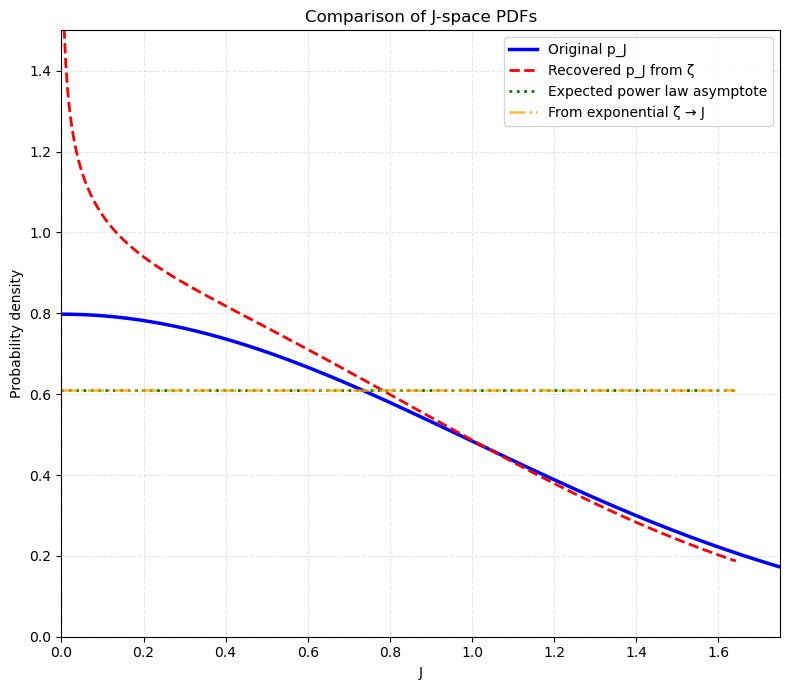

L1 difference between original and recovered p_J: 0.5920913831199122


In [18]:
# Original PDF in J-space
pJ_orig = initial_distributions_J[initial_distribution_name](J)
pJ_orig /= np.trapezoid(pJ_orig, J)  # normalize

# Converted to ζ-space
pZ = initial_distributions_zeta[initial_distribution_name]

Gamma_final = np.log(Omega0/Omega_final)
# print(Gamma_final)
n_steps = np.rint(Gamma_final/dGamma).astype(int)  # number of RG steps
# print(n_steps)

Omega = Omega0
Gamma = 0

for i in range(n_steps):
    pZ = evolve(pZ, zeta, dGamma)
    Omega = Omega - Omega * dGamma
    Gamma = Gamma + dGamma

pZ_final = pZ

J_vals, pJ_final = zeta_to_J_pdf_stable(pZ, zeta, Omega, N_J=2000)

J_vals, pJ_exp = zeta_to_J_pdf_stable(exponential_pdf(zeta, Gamma), zeta, Omega)

# print("min J:", J_vals[0], "max J:", J_vals[-1])
# print("min pJ:", pJ_final.min(), "max pJ:", pJ_recovered.max())
# print("Integral:", np.trapezoid(pJ_recovered, J_vals))

plt.figure(figsize=(8,7))

plt.plot(J, pJ_orig,
         label="Original p_J",
         linewidth=2.5,
         color="blue")

plt.plot(J_vals, pJ_final,
         label="Recovered p_J from ζ",
         linewidth=2,
         linestyle="--",
         color="red")

plt.plot(J_vals, real_power_law(J_vals, Omega, Gamma),
         label="Expected power law asymptote",
         linewidth=2,
         linestyle=":",
         color="green")

plt.plot(J_vals, pJ_exp,
         label="From exponential ζ → J",
         linewidth=1.8,
         linestyle="-.",
         color="orange",
         alpha=0.8)

# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("J")
plt.ylabel("Probability density")
plt.title("Comparison of J-space PDFs")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0,1.75)
plt.ylim(0,1.5)
plt.legend()
plt.tight_layout()
plt.show()


# Optional: check numerical difference
diff = np.trapezoid(np.abs(np.interp(J, J_vals, pJ_recovered) - pJ_orig), J)
print("L1 difference between original and recovered p_J:", diff)

# Prob density for J and zeta are stored in:
# zeta, pZ_final
# J_vals, pJ_final


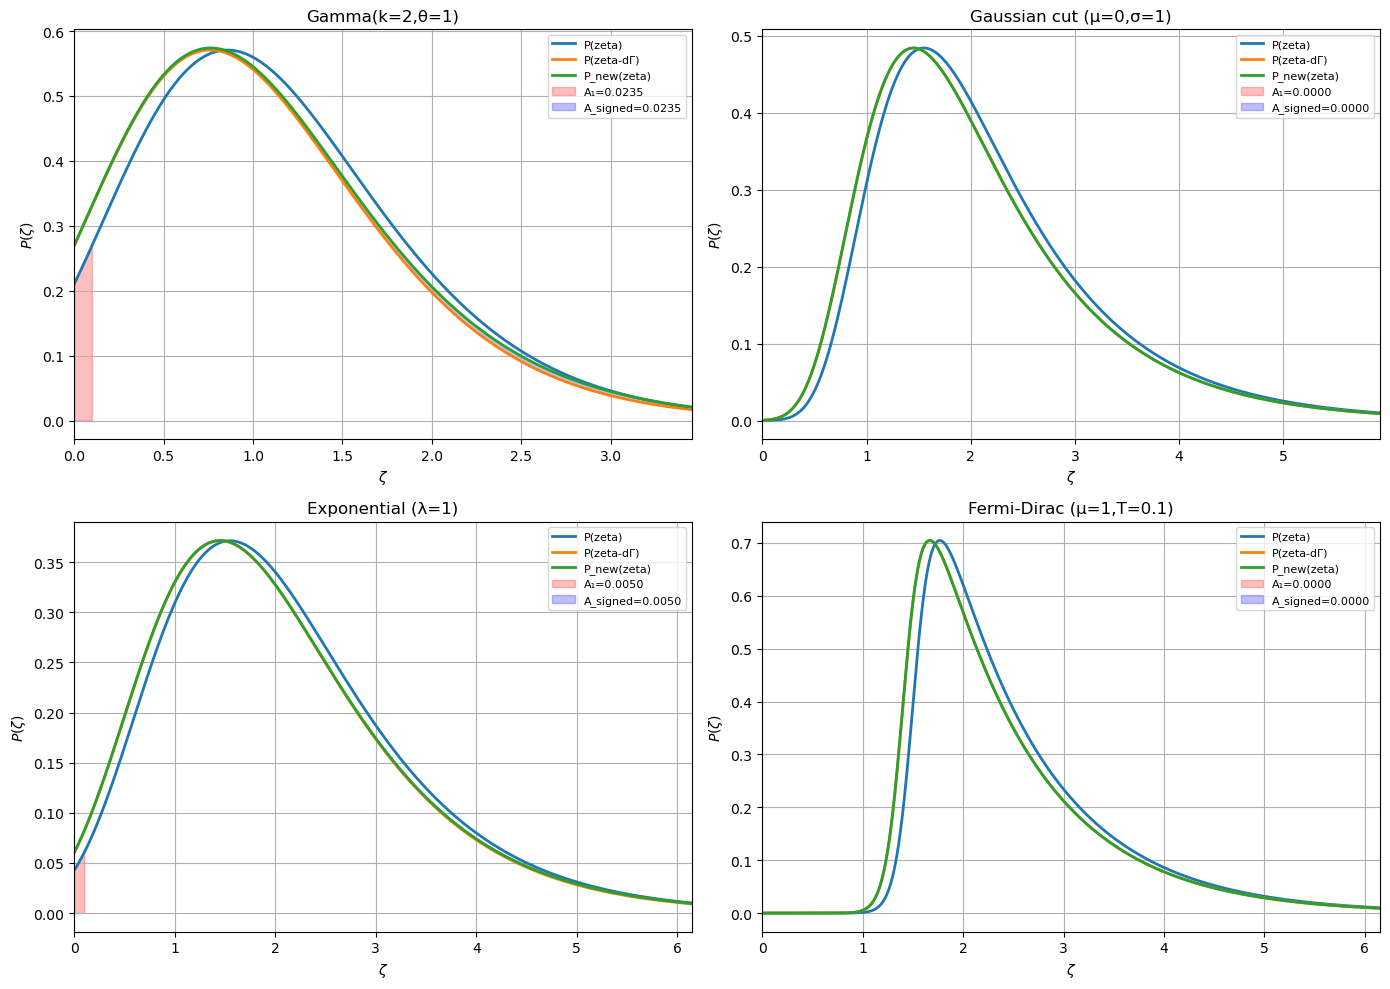

In [291]:
# ============================================
# Plot all initial distributions in ζ-space
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, P_orig) in zip(axes, initial_distributions_zeta.items()):
    # Copy array to avoid modifying original
    P = P_orig.copy()
    
    # Ensure normalization
    P /= np.trapezoid(P, zeta)

    # Evolve once
    P_new = evolve(P, zeta, dGamma)

    # Build shifted P(zeta - dGamma)
    P_shift = np.zeros_like(P)
    shift_idx = int(dGamma / dzeta)
    if shift_idx < len(P):
        P_shift[:-shift_idx] = P[shift_idx:]
    else:
        # If shift is larger than array, leave P_shift as zeros
        shift_idx = len(P) - 1

    # Compute intelligent zeta-limit for plotting
    zeta_max_plot = intelligent_xmax(zeta, P, p=0.99)

    # ------------------------------
    # Plot curves
    # ------------------------------
    ax.plot(zeta, P, label="P(zeta)", linewidth=2)
    ax.plot(zeta, P_shift, label=f"P(zeta-dΓ)", linewidth=2)
    ax.plot(zeta, P_new, label="P_new(zeta)", linewidth=2)

    # ------------------------------
    # Region 1: area under P(zeta) in [0, dGamma]
    # ------------------------------
    mask_region1 = (zeta >= 0) & (zeta <= dGamma)
    area1 = np.trapezoid(P[mask_region1], zeta[mask_region1])
    ax.fill_between(
        zeta[mask_region1], P[mask_region1],
        color="red", alpha=0.25,
        label=f"A₁={area1:.4f}"
    )

    # ------------------------------
    # Region 2: signed difference P_new - P_shift
    # ------------------------------
    diff = P_new - P_shift
    area_signed = np.trapezoid(diff, zeta)

    mask_pos = diff > 0
    mask_neg = diff < 0

    ax.fill_between(
        zeta, P_shift, P_new,
        where=mask_pos,
        color="blue", alpha=0.25,
        label=f"A_signed={area_signed:.4f}"
    )
    ax.fill_between(
        zeta, P_shift, P_new,
        where=mask_neg,
        color="blue", alpha=0.25
    )

    # ------------------------------
    # Formatting
    # ------------------------------
    ax.set_xlim(0, zeta_max_plot)
    ax.set_xlabel(r"$\zeta$")
    ax.set_ylabel(r"$P(\zeta)$")
    ax.set_title(name)
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


1.0015664995186389
10


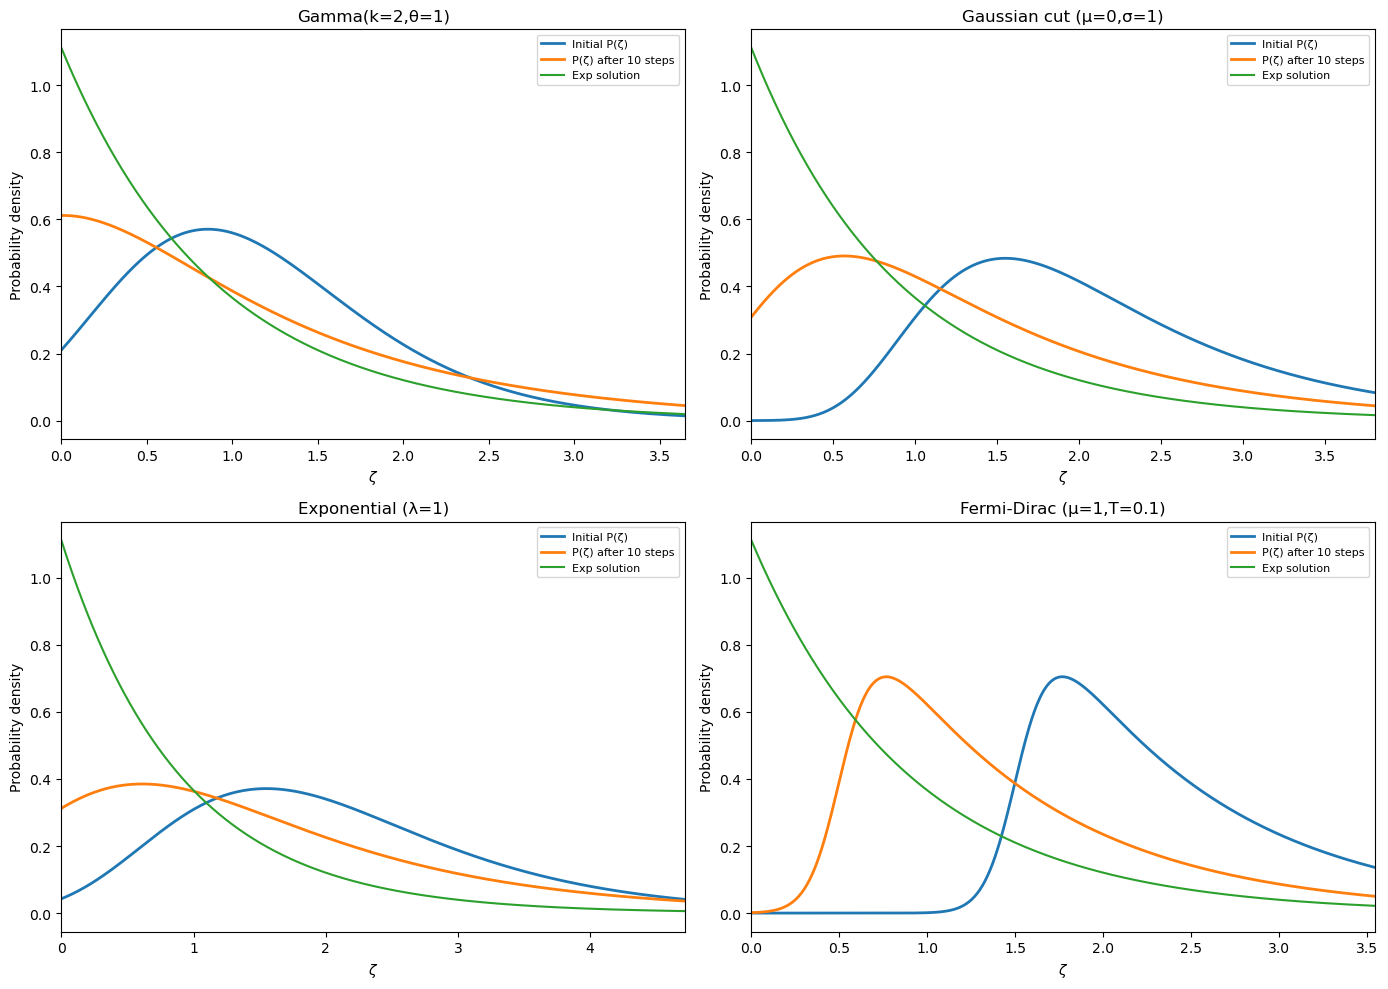

In [292]:
# ============================================
#  Evolution for all 4 initial distributions
# ============================================

Gamma_final = np.log(Omega0/Omega_final)
print(Gamma_final)
n_steps = np.rint(Gamma_final/dGamma).astype(int)  # number of RG steps
print(n_steps)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# To store diagnostics for all distributions
results = {}

for ax, (name, P_init_orig) in zip(axes, initial_distributions_zeta.items()):
    
    # ---------------------------------------------------------
    # Build initial distribution (copy to avoid modifying original)
    # ---------------------------------------------------------
    P_init = P_init_orig.copy()
    P_init /= np.trapezoid(P_init, zeta)  # normalize on zeta grid

    # ---------------------------------------------------------
    # Initialize storage lists
    # ---------------------------------------------------------
    Gammas = []
    Means = []
    Sigmas = []
    Errors = []

    # ---------------------------------------------------------
    # Evolve for n_steps
    # ---------------------------------------------------------
    P_current = P_init.copy()
    for step in range(n_steps):

        Gamma = (step) * dGamma
        Gammas.append(Gamma)

        # diagnostics BEFORE evolution step
        m = mean_P(zeta, P_current)
        s = sigma_P(zeta, P_current)
        Means.append(m)
        Sigmas.append(s)

        # exponential reference PDF
        P_ref = exponential_pdf(zeta, Gamma if Gamma > 0 else dGamma)
        err = L1_distance(P_current, P_ref, zeta)
        Errors.append(err)

        # evolve one RG step
        P_current = evolve(P_current, zeta, dGamma)

    # save diagnostics
    results[name] = {
        "Gamma": np.array(Gammas),
        "Mean": np.array(Means),
        "Sigma": np.array(Sigmas),
        "Error": np.array(Errors)
    }

    # ---------------------------------------------------------
    # Intelligent plot cutoff (based on final PDF)
    # ---------------------------------------------------------
    zeta_max_plot = intelligent_xmax(zeta, P_current, p=0.95)

    # ---------------------------------------------------------
    # Plot
    # ---------------------------------------------------------
    ax.plot(zeta, P_init, label="Initial P(ζ)", linewidth=2)
    ax.plot(zeta, P_current, label=f"P(ζ) after {n_steps} steps", linewidth=2)
    ax.plot(zeta, exponential_pdf(zeta, Gamma), label="Exp solution")

    ax.set_xlim(0, zeta_max_plot)
    ax.set_title(name)
    ax.set_xlabel(r"$\zeta$")
    ax.set_ylabel("Probability density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
